In [1]:
% matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append(r'C:\Users\MoAda\Documents\Physics\FP\F20-MagnetoOpticTrap')

In [2]:
import lib.constants as c
import matplotlib.pyplot as plt

## Loading rates
### 1 - Starting point

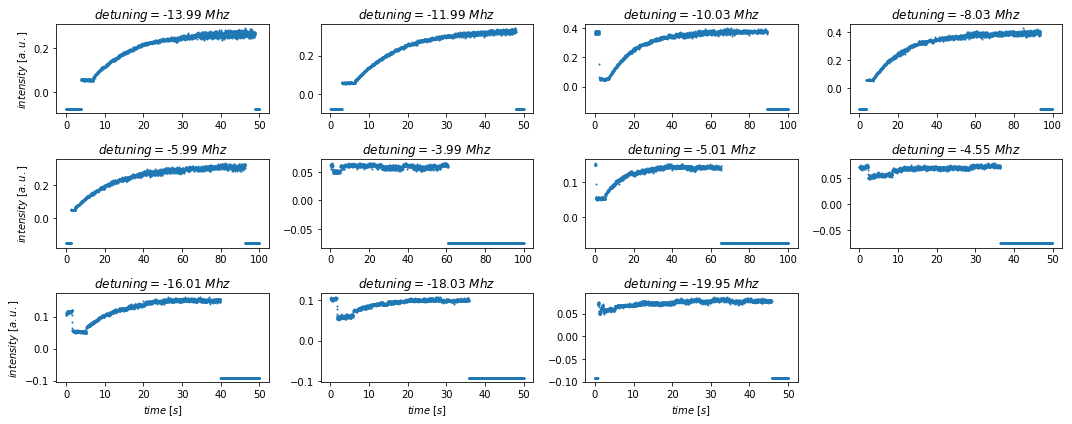

In [3]:
from lib.parse_plot_data import make_oscilloscope_df, plot_dfs
plt_style = ['$detuning = $', c.DETUNING_DICT, '$ \ Mhz$',  # Title, 1: start, 2: link of the dict, 3: end
             '$intensity \ [a.u.]$',  # ylabel
             '$time \ [s]$']  # xlabel
dfs = make_oscilloscope_df(c.loading_path)
plot_dfs(dfs, plt_style)
plt.show()

### 2 - Filtering values that are equal to the minimum value and fitting of loading curves

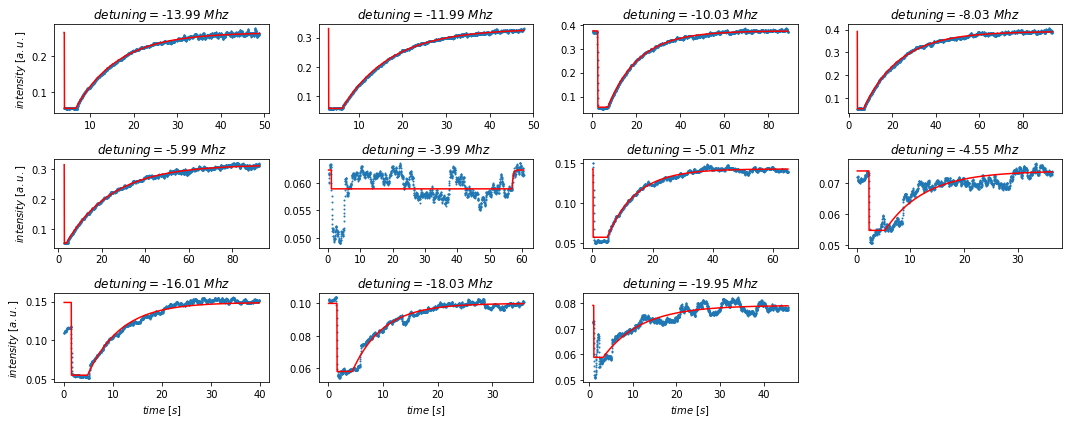

In [4]:
from lib.filter_data import filter_loading
from lib.fit_data import fit_loading_dfs
dfs = filter_loading(dfs, rolling=10)
dfs_fit, fit_df = fit_loading_dfs(dfs, offset_on=False)
plot_dfs(dfs_fit, plt_style)
plt.show()

### 3 - Analysis of the loading curves

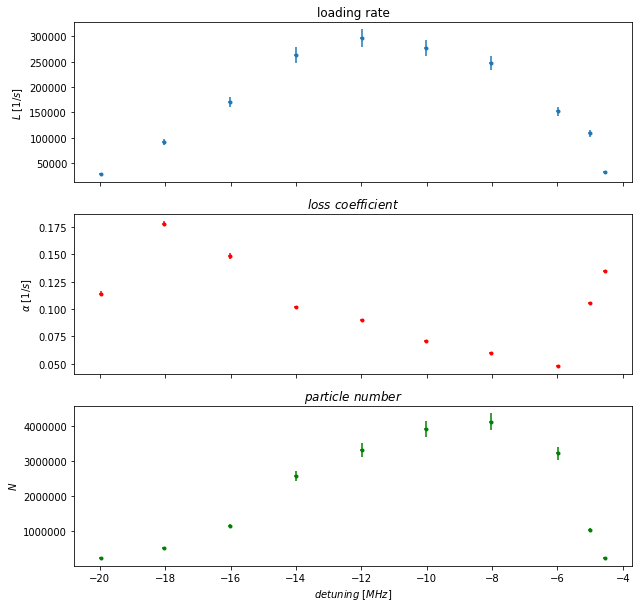

In [5]:
from lib.analysis import loading_analysis
loading_analysis(fit_df)
plt.show()

### Release, Recapture

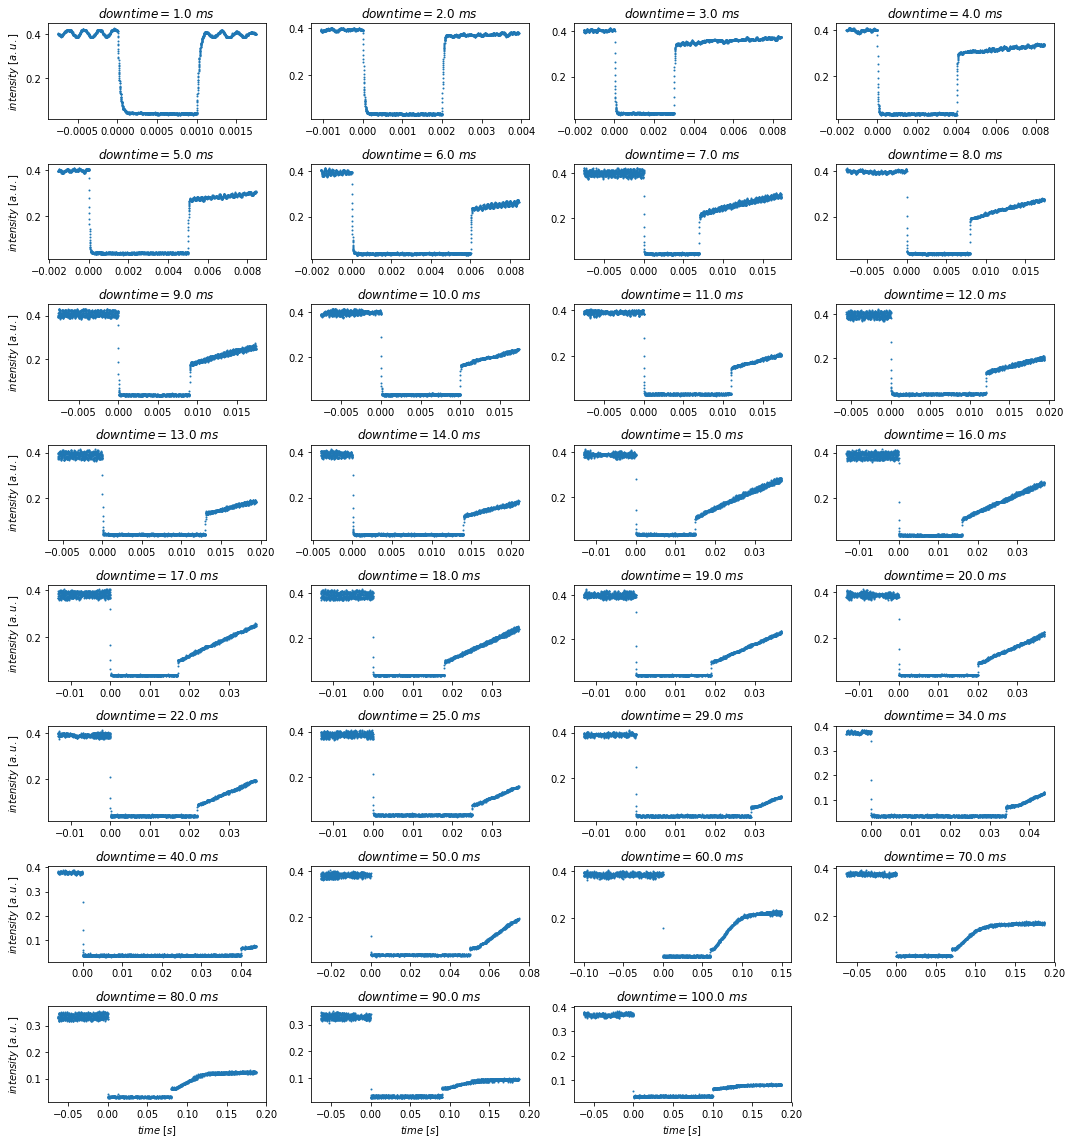

In [6]:
plt_style_rr = ['$down time = $', c.DURATION_DICT, '$ \ ms$',  # Title, 1: start, 2: link of the dict, 3: end
                '$intensity \ [a.u.]$',  # ylabel
                '$time \ [s]$']  # xlabel
dfs_rr = make_oscilloscope_df(c.temperature_path)
plot_dfs(dfs_rr, plt_style_rr)
plt.show()

### Filtering Release, Recapture data and Fit

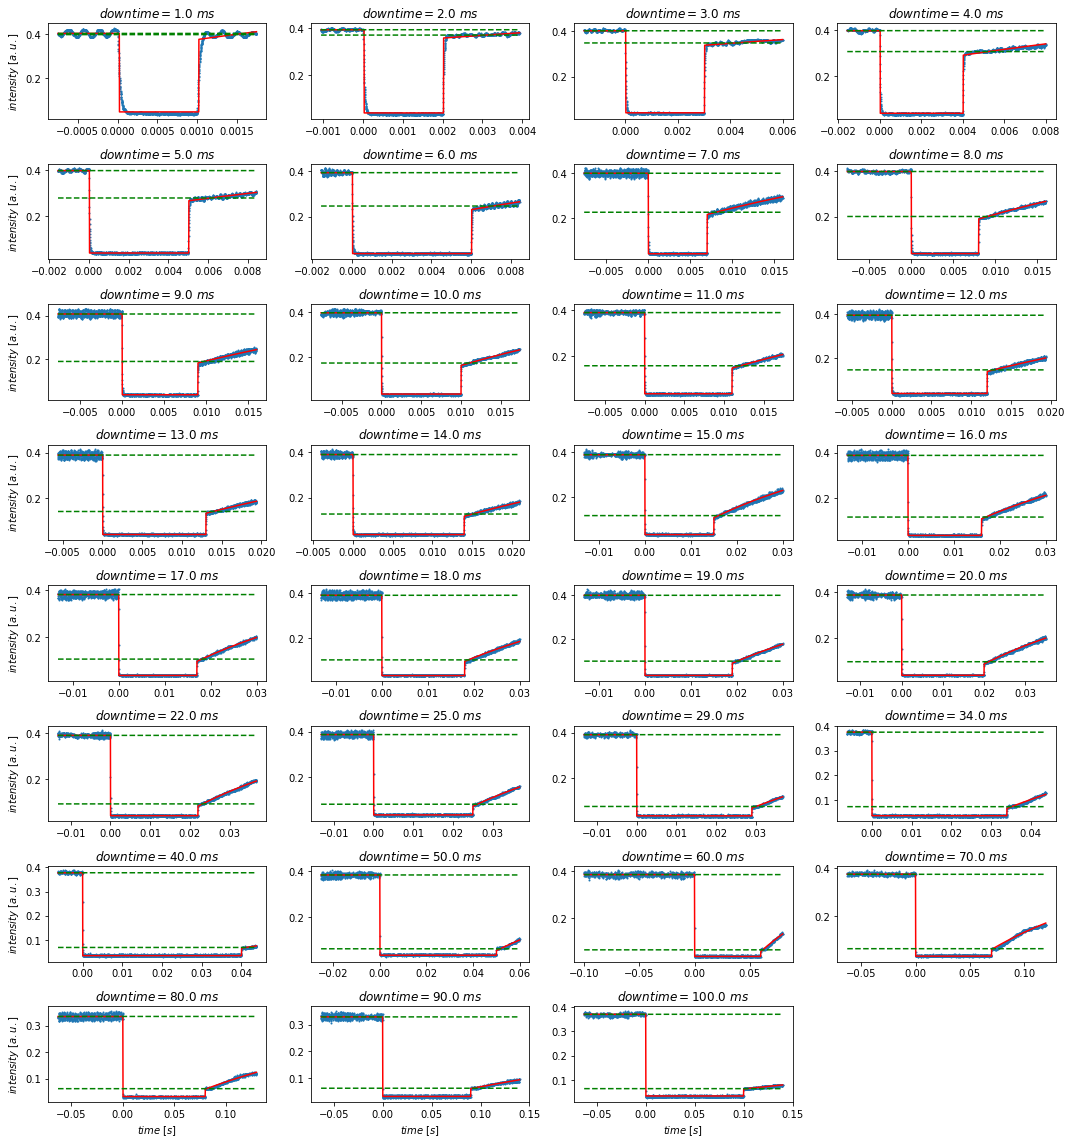

In [7]:
from lib.filter_data import filter_recapture
from lib.analysis import calculate_mean
dfs_rr = filter_recapture(dfs_rr)
dfs_fit_rr, fit_df_rr = fit_loading_dfs(dfs_rr, offset_on=True)
mean = calculate_mean(fit_df_rr, dfs_rr)
plot_dfs(dfs_fit_rr, plt_style_rr, recapture=mean)
plt.show()
# fit_df_rr.to_excel(c.save_rr_path)

### Analysis of the recapture experiment

temperature in K: 0.0003805374384656768, error: 1.4876700199615795e-05


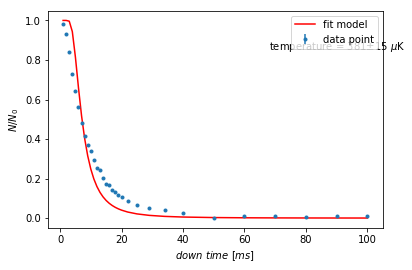

In [8]:
from lib.analysis import recapture_analysis
recapture_analysis(mean)
plt.show()

## Spectroscopy
### 1 - Loading spectroscopy data

In [9]:
from lib.parse_plot_data import make_spectroscopy_df, plot_dfs_spectroscopy
dfs_spec = make_spectroscopy_df(c.spectroscopy_path)
#fig, axes = plot_dfs_spectroscopy(dfs_spec, max_column_number=3, plot_PDH_out=True, plot_fit=False)
#plt.show()

### 2 - Calibrating the frequency scale

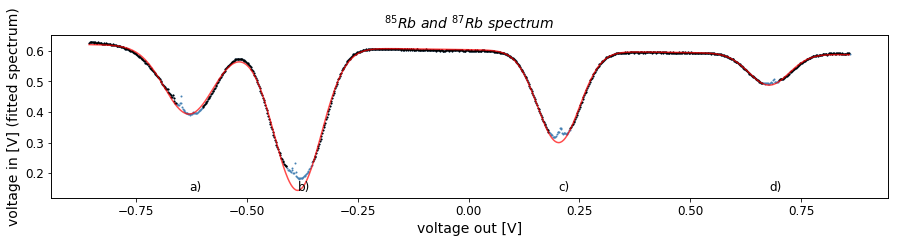

calibration factor: 1.3074547155780372, zero definition: -0.6303634847621387
multiplet df           separation in frequency [GHz]  separation error [GHz]
87f287f1                       6.834683                0.532377
87f285f3                       1.281921                0.409172
85f285f3                       3.074103                0.408904
85f287f1                       2.478659                0.369389


In [10]:
from lib.util import mask_dfs, get_definition_zero, get_multiplet_df, get_multiplet_separation
from lib.fit_data import fit_spectroscopy_dfs
dfs_compl_spec = dfs_spec[8:]
dfs_compl_spec = mask_dfs(dfs_compl_spec, all_masks=[[(-0.66, -0.60), (-0.41, -0.35),
                                                      (0.18, 0.23), (0.66, 0.7)]])

params_poly_gauss = [{'gauss1_amp': -0.2, 'gauss2_amp': -0.4, 'gauss3_amp': -0.3, 'gauss4_amp': -0.1,
                      'gauss1_cen': -0.6, 'gauss2_cen': -0.4, 'gauss3_cen': 0.23, 'gauss4_cen': 0.7,
                      'gauss1_sig': 0.1, 'gauss2_sig': 0.1, 'gauss3_sig': 0.1, 'gauss4_sig': 0.1,
                      'gauss1_off': 0.6, 'gauss2_off': 0.6, 'gauss3_off': 0.6, 'gauss4_off': 0.6,
                      'linear1_intercept': 0.7, 'linear2_intercept': 0.7,
                      'linear1_slope': -0.004, 'linear2_slope': -0.004}]

dfs_compl_spec, fit_df_compl_spec = fit_spectroscopy_dfs(dfs_compl_spec,
                                                         fct='poly_gaussian',
                                                         init_params=params_poly_gauss)

fig, axes = plot_dfs_spectroscopy(dfs_compl_spec,
                                  max_column_number=1,
                                  plot_PDH_out=False,
                                  plot_fit=True,
                                  fit_data=fit_df_compl_spec,
                                  x_label='voltage out [V]', y_label='voltage in [V]')
plt.show()

calibration_factor, calibration_factor_err = get_multiplet_separation(fit_df_compl_spec,
                                                                      left=1,
                                                                      right=4)

definition_zero, definition_zero_error = get_definition_zero(fit_df_compl_spec)
print('calibration factor: {}, zero definition: {}'.format(calibration_factor, definition_zero))

df_multiplet_sep = get_multiplet_df(fit_df_compl_spec)
# df_multiplet_sep.to_excel(c.save_multiplet_path)

### Gaussian fits of the transitions (unzoomed)

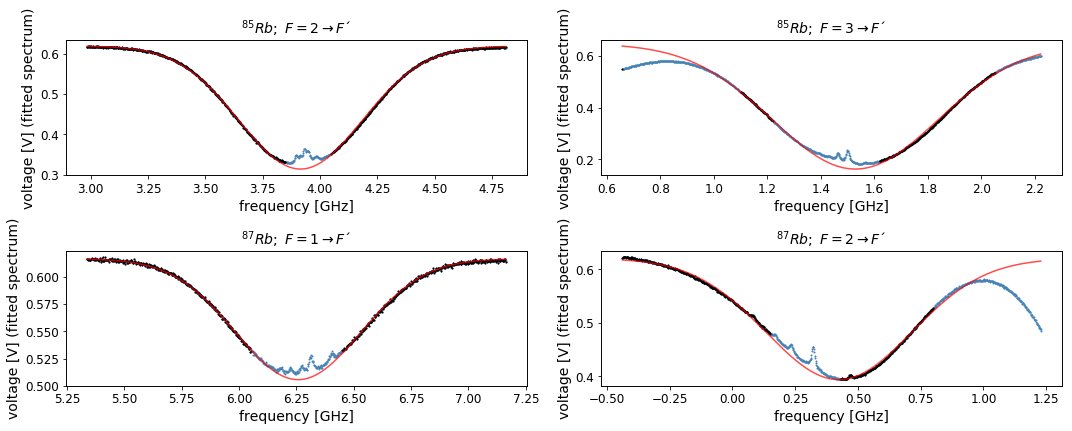

In [11]:
from lib.filter_data import filter_zoomed_spectroscopy, calibrate_voltage_to_freq_scale
from lib.analysis import save_temp_from_finestructure_in_fit_df
dfs_spec_all = dfs_spec.copy()
dfs_spec = filter_zoomed_spectroscopy(dfs_spec_all,
                                      return_zoomed=False,
                                      return_entire=False)

dfs_spec = calibrate_voltage_to_freq_scale(dfs_spec,
                                           calibration_factor=calibration_factor,
                                           definition_zero=definition_zero)

dfs_spec = mask_dfs(dfs_spec, all_masks=[[(3.85, 4.05)],
                                         [(0.6, 1.1), (1.22, 1.62), (2.05, 2.3)],
                                         [(6.05, 6.45)],
                                         [(0.15, 0.43), (0.8, 1.3)]])

params_gauss = [
    {'amp': -0.2064, 'cen': 3.9153, 'sig': 0.27, 'off': 0.62},
    {'amp': -0.4, 'cen': 1.4, 'sig': 0.3, 'off': 0.62},
    {'amp': -0.076, 'cen': 6.2575, 'sig': 0.27, 'off': 0.62},
    {'amp': -0.5, 'cen': 0.25, 'sig': 0.3, 'off': 0.62}
]

dfs_spec, fit_df_spec = fit_spectroscopy_dfs(dfs_spec, fct='gaussian', init_params=params_gauss)

fig, axes = plot_dfs_spectroscopy(dfs_spec,
                                  max_column_number=2,
                                  plot_PDH_out=False,
                                  plot_fit=True,
                                  x_label='frequency [GHz]', y_label='voltage [V]')

# plt.show()
fit_df_spec = save_temp_from_finestructure_in_fit_df(fit_df_spec)
# fit_df_spec.to_excel(c.save_finestructure_path)

### Fit hyperfine structure to determine linewidths

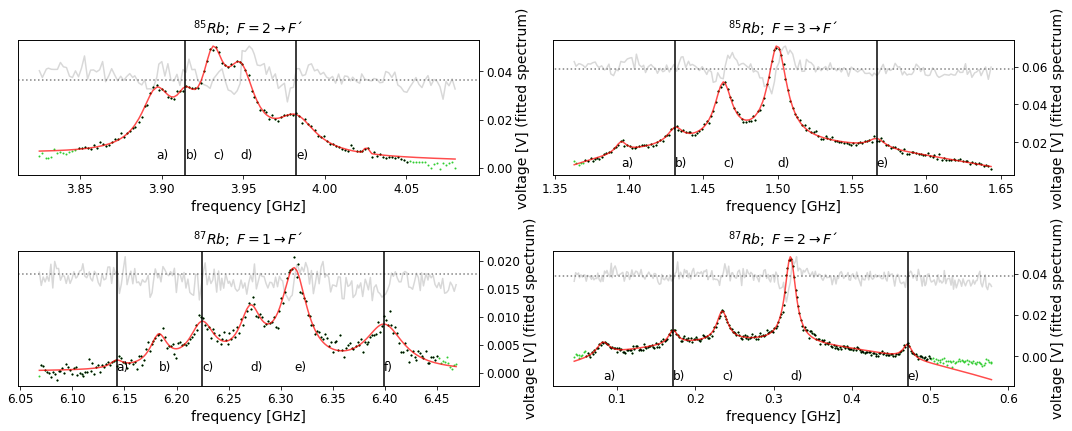

In [12]:
from lib.filter_data import subtract_gaussian_fit
dfs_spec_hyperfine = dfs_spec.copy()
dfs_spec_hyperfine = subtract_gaussian_fit(dfs_spec_hyperfine)
column_name = 'Aux in minus Best fit [V]'

masks = [[(c.START_TOKEN, 3.85), (4.05, c.STOP_TOKEN)],
         [(c.START_TOKEN, 1.37), (1.65, c.STOP_TOKEN)],
         [(c.START_TOKEN, 6.07), (6.45, c.STOP_TOKEN)],
         [(c.START_TOKEN, 0.06), (0.5, c.STOP_TOKEN)]]

dfs_spec_hyperfine = mask_dfs(dfs_spec_hyperfine, all_masks=masks,
                              column_to_be_masked=column_name,
                              split_masks=False)

params_poly_lorentzian = [
    {'number_unique_lorentzians': 6,
     'lorentzian1_amp': 0.02, 'lorentzian1_gamma': 0.01, 'lorentzian1_cen': 3.9,
     'lorentzian2_amp': 0.01, 'lorentzian2_gamma': 0.001, 'lorentzian2_cen': 3.92,
     'lorentzian3_amp': 0.05, 'lorentzian3_gamma': 0.01, 'lorentzian3_cen': 3.935,
     'lorentzian4_amp': 0.04, 'lorentzian4_gamma': 0.01, 'lorentzian4_cen': 3.95,
     'lorentzian5_amp': 0.02, 'lorentzian5_gamma': 0.01, 'lorentzian5_cen': 3.98,
     'lorentzian6_amp': 0.01, 'lorentzian6_gamma': 0.001, 'lorentzian6_cen': 4.025,
     'linear1_intercept': 0, 'linear1_slope': 0},
    {'number_unique_lorentzians': 6,
     'lorentzian1_amp': 0.005, 'lorentzian1_gamma': 0.005, 'lorentzian1_cen': 1.3955,
     'lorentzian2_amp': 0.005, 'lorentzian2_gamma': 0.006, 'lorentzian2_cen': 1.4315,
     'lorentzian3_amp': 0.02, 'lorentzian3_gamma': 0.007, 'lorentzian3_cen': 1.46,
     'lorentzian4_amp': 0.001, 'lorentzian4_gamma': 0.008, 'lorentzian4_cen': 1.50,
     'lorentzian5_amp': 0.0009, 'lorentzian5_gamma': 0.007, 'lorentzian5_cen': 1.57,
     'lorentzian6_amp': 0.009, 'lorentzian6_gamma': 0.07994732, 'lorentzian6_cen': 1.55,  # lorentz6 only for help
     'linear1_intercept': 0.01, 'linear1_slope': 0},
    {'number_unique_lorentzians': 6,
     'lorentzian1_amp': 0.002, 'lorentzian1_gamma': 0.001, 'lorentzian1_cen': 6.145,
     'lorentzian2_amp': 0.007, 'lorentzian2_gamma': 0.01, 'lorentzian2_cen': 6.18,
     'lorentzian3_amp': 0.011, 'lorentzian3_gamma': 0.01, 'lorentzian3_cen': 6.215,
     'lorentzian4_amp': 0.017, 'lorentzian4_gamma': 0.01, 'lorentzian4_cen': 6.27,
     'lorentzian5_amp': 0.02, 'lorentzian5_gamma': 0.01, 'lorentzian5_cen': 6.31,
     'lorentzian6_amp': 0.007, 'lorentzian6_gamma': 0.01, 'lorentzian6_cen': 6.41,
     'linear1_intercept': 0, 'linear1_slope': 0},
    {'number_unique_lorentzians': 6,
     'lorentzian1_amp': 0.0004, 'lorentzian1_gamma': 0.006, 'lorentzian1_cen': 0.09,
     'lorentzian2_amp': 0.0004, 'lorentzian2_gamma': 0.006, 'lorentzian2_cen': 0.171,
     'lorentzian3_amp': 0.0004, 'lorentzian3_gamma': 0.008, 'lorentzian3_cen': 0.23,
     'lorentzian4_amp': 0.001, 'lorentzian4_gamma': 0.008, 'lorentzian4_cen': 0.32,
     'lorentzian5_amp': 0.0004, 'lorentzian5_gamma': 0.006, 'lorentzian5_cen': 0.48,
     'lorentzian6_amp': 94.970, 'lorentzian6_gamma': 0.5848, 'lorentzian6_cen': 0.476,  # lorentz6 only for help
     'linear1_intercept': 0.1, 'linear1_slope': 0}]

dfs_spec_hyperfine, fit_df_spec_hyperfine = fit_spectroscopy_dfs(dfs_spec_hyperfine, fct='poly_lorentzian',
                                                                 column_to_fit=column_name,
                                                                 use_multiple_lorentzians=True,
                                                                 init_params=params_poly_lorentzian,
                                                                 use_splitted_masks=False)

highlighted_lorentz = [[2, 5], [2, 5], [1, 3, 6], [2, 5]]
usable_lorentz = [5, 5, 6, 5]

fig, axes = plot_dfs_spectroscopy(dfs_spec_hyperfine,
                                  max_column_number=2,
                                  fit_data=fit_df_spec_hyperfine,
                                  plot_initial=False,
                                  plot_PDH_out=True,
                                  plot_fit=True,
                                  plot_deriv=False,
                                  plot_data_with_subtracted_fit=True,
                                  use_splitted_masks=False,
                                  use_automated_fit_plot_barrier=False,
                                  use_global_zoom_for_hyperfine=True,
                                  column_name=column_name,
                                  masks=masks,
                                  usable_lorentz=usable_lorentz,
                                  highlighted_lorentz=highlighted_lorentz,
                                  x_label='frequency [GHz]', y_label='voltage [V]')

plt.show()
# fit_df_spec_hyperfine.to_excel(c.save_hyperfinestructure_path)